In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
import geohash
from sklearn.metrics import mean_squared_error
import random
import math
import datetime
import geopy as gp
from geopy.distance import vincenty

### Goal: Explore the possiblity of predicting a destination (lat/long) based on the pickup location, time & day

### Note: Go directly to step 3 if you had performed 1 & 2 earlier

## 1. Load the aggregated data from the CSV file

In [3]:
# Each line is of the format:

#pickupGeohash, dropOffGeohash,time_num,day_of_week, count
# File is also available here: https://s3.amazonaws.com/testsetu/nyc/final/groupbydestn/singlefile/part-00000
names = ["pickup_geohash","dropoff_geohash","time_num","day_of_week", "count"]
df=pd.read_csv("./tmplocaldata/final/groupbydestn/part-00000", header=None, names = names)
#df = df.sample(n=10000000,weights=df['count'], replace=True)
print df.shape

(15285988, 5)


## 2. Feature Extraction

In [4]:
# Get the longitude and latitude from the geohash
def decodegeo(geo, which):
    if len(geo) >= 6:
        geodecoded = geohash.decode(geo)
        return geodecoded[which]
    else:
        return 0
    
def further_data_prep(df):
  
    df['time_sin'] = (df['time_num'] * 2 * math.pi).apply(math.sin)
    df['time_cos'] = (df['time_num'] * 2 * math.pi).apply(math.cos)
    df['pickup_lat'] = df['pickup_geohash'].apply(lambda geo: decodegeo(geo, 0))
    df['pickup_long'] = df['pickup_geohash'].apply(lambda geo: decodegeo(geo, 1))
    df['dropoff_lat'] = df['dropoff_geohash'].apply(lambda geo: decodegeo(geo, 0))
    df['dropoff_long'] = df['dropoff_geohash'].apply(lambda geo: decodegeo(geo, 1))
    
    return df

In [5]:
df = further_data_prep(df)

In [9]:
df.to_csv("./tmplocaldata/final/groupbydestn/pickup_dropoff_aggregated_with_feat_ext.csv", index=False)

## 3. Train-test split

In [2]:
%time df=pd.read_csv("./tmplocaldata/final/groupbydestn/pickup_dropoff_aggregated_with_feat_ext.csv")

Wall time: 28.3 s


#### Rescale longitude in the scale of latitude: so the RMSE error function in the ML algorithm works properly

In [3]:
df['pickup_long_rescaled'] =  np.interp(df['pickup_long'], [-180,180], [-90,90])
df['dropoff_long_rescaled'] =  np.interp(df['dropoff_long'], [-180,180], [-90,90])

In [4]:
df.head()

,pickup_geohash,dropoff_geohash,time_num,day_of_week,count,time_sin,time_cos,pickup_lat,pickup_long,dropoff_lat,dropoff_long,pickup_long_rescaled,dropoff_long_rescaled
0,dr5rtk,dr5rsj,0.416667,4,2,0.500000,-0.866025,40.718079,-73.943481,40.723572,-73.998413,-36.971741,-36.999207
1,dr5x0z,dr5xcf,0.683333,0,2,-0.913545,-0.406737,40.646667,-73.789673,40.751038,-73.745728,-36.894836,-36.872864
2,dr72rd,dr782h,0.650000,3,2,-0.809017,-0.587785,40.838928,-73.844604,40.849915,-73.822632,-36.922302,-36.911316
3,dr5rvn,dr5rt5,0.083333,2,11,0.500000,0.866025,40.773010,-73.954468,40.712585,-73.954468,-36.977234,-36.977234
4,dr72jd,dr72m3,0.050000,0,3,0.309017,0.951057,40.794983,-73.932495,40.833435,-73.943481,-36.966248,-36.971741


#### Perform the train-test split

In [5]:
# best practice:  random_state=42
#trainSetSampleSize = 10000000
testSetSize = 2000000
testSetPosns = np.random.choice(df.shape[0],testSetSize, replace = False)
testSet = df.iloc[testSetPosns]
trainSet = df.drop(testSetPosns)

#### Weighting (optional): not required as it is not able to produce a better model

In [45]:
#np.random.choice(a, size=2, replace = False, p=p)
totalCount =  trainSet['count'].sum()
trainSet["weight"] = trainSet['count']/totalCount

In [52]:
trainSet = trainSet.sample(n=trainSetSampleSize,weights=trainSet['weight'], replace=True)
#trainSet = trainSet.sample(n=trainSetSampleSize,weights=trainSet['count'], replace=True)

#### Initialize the train & test sets

In [6]:
X_train = trainSet[['time_num', 'time_sin', 'time_cos','day_of_week', 'pickup_lat', 'pickup_long_rescaled']]
y_train = trainSet[['dropoff_lat', 'dropoff_long_rescaled']]

X_test = testSet[['time_num', 'time_sin', 'time_cos','day_of_week', 'pickup_lat', 'pickup_long_rescaled']]
y_test = testSet[['dropoff_lat', 'dropoff_long_rescaled']]

## 4. Machine learning

In [7]:
# Funtion for cross-validation over a grid of parameters

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None, verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func, verbose=verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose=verbose)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_, gs.scorer_
    print "Best score: ", gs.best_score_
    best = gs.best_estimator_
    return best

In [8]:
# Create a Random Forest Regression estimator
estimator = RandomForestRegressor(n_estimators=20, n_jobs=-1)

In [26]:
%%time

# Define a grid of parameters over which to optimize the random forest
# We will figure out which number of trees is optimal
parameters = {"n_estimators": [20],
              "max_features": ["auto"], # ["auto","sqrt","log2"]
              "max_depth": [20]}
best = cv_optimize(estimator, parameters, X_train, y_train, n_folds=5, verbose=1)
#best = cv_optimize(estimator, parameters, X_train, y_train, n_folds=2, score_func='mean_squared_error', verbose=3)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] max_features=auto, n_estimators=20, max_depth=20 ................
[CV]  max_features=auto, n_estimators=20, max_depth=20, score=0.162738 - 3.2min
[CV] max_features=auto, n_estimators=20, max_depth=20 ................
[CV]  max_features=auto, n_estimators=20, max_depth=20, score=0.155466 - 3.4min

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.6min finished



BEST {'max_features': 'auto', 'n_estimators': 20, 'max_depth': 20} 0.159101967745 [mean: 0.15910, std: 0.00364, params: {'max_features': 'auto', 'n_estimators': 20, 'max_depth': 20}] <function _passthrough_scorer at 0x000000001F0627B8>
Best score:  0.159101967745
Wall time: 13min 41s


In [27]:
#No sampling + rescaled longitude: 20 estimators, 20 depth
print "RMSE= ",np.sqrt(mean_squared_error(best.predict(X_test),y_test))

RMSE=  0.0817812139499


#### Optional step: re-running the above model with more trees, CV folds & depth

In [14]:
%%time

# Define a grid of parameters over which to optimize the random forest
# We will figure out which number of trees is optimal
parameters = {"n_estimators": [50],
              "max_features": ["auto"], # ["auto","sqrt","log2"]
              "max_depth": [50]}
best = cv_optimize(estimator, parameters, X_train, y_train, n_folds=5,score_func='mean_squared_error', verbose=1)
#best = cv_optimize(estimator, parameters, X_train, y_train, n_folds=2, score_func='mean_squared_error', verbose=3)
print "RMSE= ",np.sqrt(mean_squared_error(best.predict(X_test),y_test))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed: 13.5min
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 67.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
BEST {'max_features': 'auto', 'n_estimators': 50, 'max_depth': 50} -0.00686534862405 [mean: -0.00687, std: 0.00017, params: {'max_features': 'auto', 'n_estimators': 50, 'max_depth': 50}] make_scorer(mean_squared_error, greater_is_better=False)
Best score:  -0.00686534862405
RMSE=  0.0812417975221
Wall time: 1h 24min 52s


In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, './models/dest_model.pkl') 

## Evaluate results

In [15]:
%%time

# Fit the best Random Forest and calculate R^2 values for training and test sets

reg=best.fit(X_train, y_train)
training_accuracy = reg.score(X_train, y_train)
test_accuracy = reg.score(X_test, y_test)
print "############# based on standard predict ################"
print "R^2 on training data: %0.4f" % (training_accuracy)
print "R^2 on test data:     %0.4f" % (test_accuracy)

############# based on standard predict ################
R^2 on training data: 0.2708
R^2 on test data:     0.1626
Wall time: 18min 54s


In [16]:
# Calculate the Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(reg.predict(X_test),y_test))
print "RMSE = %0.3f " % rmse
print "Latitude RMSE = ",rmse*69," miles"
scaledbackLongRMSE = np.interp(rmse, [-90,90], [-180,180])
print "Longitude RMSE = ",scaledbackLongRMSE*53," miles"

RMSE = 0.081 
Latitude RMSE =  5.61220921856  miles
Longitude RMSE =  8.62165474155  miles


In [17]:
# What are the most important features?
import operator
dict_feat_imp = dict(zip(list(X_test.columns.values),reg.feature_importances_))

sorted_features = sorted(dict_feat_imp.items(), key=operator.itemgetter(1), reverse=True)
sorted_features

[('pickup_lat', 0.54077211318033069),
 ('pickup_long_rescaled', 0.29392547858766693),
 ('day_of_week', 0.051206342269280024),
 ('time_sin', 0.039954843986436381),
 ('time_num', 0.039568463398994218),
 ('time_cos', 0.034572758577291481)]

In [18]:
# Show some of the predictions vs actual
#actualPredictedDf = pd.DataFrame(np.hstack(y_test, reg.predict(X_test), names=["act_dropoff_lat", "act_dropoff_lat_rescaled","pred_dropoff_lat", "pred_dropoff_lat_rescaled"])

actualPredictedDf = pd.DataFrame(np.hstack((reg.predict(X_test), y_test.values)),columns=["pred_dropoff_lat", "pred_dropoff_long_rescaled", "act_dropoff_lat", "act_dropoff_long_rescaled"])
actualPredictedDf.head()

,pred_dropoff_lat,pred_dropoff_long_rescaled,act_dropoff_lat,act_dropoff_long_rescaled
0,40.836495,-36.947423,40.855408,-36.949768
1,40.685634,-36.980992,40.619202,-37.004700
2,40.789750,-36.975287,40.663147,-36.900330
3,40.778937,-36.972001,40.674133,-36.999207
4,40.744723,-36.964568,40.701599,-36.911316


#### Scaleback the longitudes to original scale

In [19]:
actualPredictedDf['pred_dropoff_long'] =  np.interp(actualPredictedDf['pred_dropoff_long_rescaled'],[-90,90], [-180,180])
actualPredictedDf['act_dropoff_long'] =  np.interp(actualPredictedDf['act_dropoff_long_rescaled'], [-90,90], [-180,180])
actualPredictedDf.drop("pred_dropoff_long_rescaled", inplace=True, axis=1)
actualPredictedDf.drop("act_dropoff_long_rescaled", inplace=True , axis=1)
actualPredictedDf.head()

,pred_dropoff_lat,act_dropoff_lat,pred_dropoff_long,act_dropoff_long
0,40.836495,40.855408,-73.894847,-73.899536
1,40.685634,40.619202,-73.961985,-74.009399
2,40.789750,40.663147,-73.950575,-73.800659
3,40.778937,40.674133,-73.944002,-73.998413
4,40.744723,40.701599,-73.929136,-73.822632


#### Evaluate performance of model based on scaled back longitude data (to original range)

In [20]:
def getLatLongBasedOnGeocode(lat, longitude, accuracy = 6):
    gh = geohash.encode(lat, longitude, accuracy)
    ghLatLong = geohash.decode(gh)
    return ghLatLong[0], ghLatLong[1]

In [21]:
getLatLongBasedOnGeocode(40.745861, -73.917152)

(40.74554443359375, -73.9215087890625)

In [22]:
actualPredictedDf["pred_dropoff_lat_from_gh"], actualPredictedDf["pred_dropoff_long_from_gh"] = zip(*actualPredictedDf.apply(lambda x: getLatLongBasedOnGeocode(x['pred_dropoff_lat'], x['pred_dropoff_long'], 6), axis=1))

In [23]:
actualPredictedDf["act_dropoff_lat_from_gh"], actualPredictedDf["act_dropoff_long_from_gh"] = zip(*actualPredictedDf.apply(lambda x: getLatLongBasedOnGeocode(x['act_dropoff_lat'], x['act_dropoff_long'], 6), axis=1))

In [24]:
actualPredictedDf = actualPredictedDf[["act_dropoff_lat","act_dropoff_long","act_dropoff_lat_from_gh","act_dropoff_long_from_gh","pred_dropoff_lat","pred_dropoff_long","pred_dropoff_lat_from_gh","pred_dropoff_long_from_gh" ]]
actualPredictedDf.head()

,act_dropoff_lat,act_dropoff_long,act_dropoff_lat_from_gh,act_dropoff_long_from_gh,pred_dropoff_lat,pred_dropoff_long,pred_dropoff_lat_from_gh,pred_dropoff_long_from_gh
0,40.855408,-73.899536,40.855408,-73.899536,40.836495,-73.894847,40.838928,-73.899536
1,40.619202,-74.009399,40.619202,-74.009399,40.685634,-73.961985,40.685120,-73.965454
2,40.663147,-73.800659,40.663147,-73.800659,40.789750,-73.950575,40.789490,-73.954468
3,40.674133,-73.998413,40.674133,-73.998413,40.778937,-73.944002,40.778503,-73.943481
4,40.701599,-73.822632,40.701599,-73.822632,40.744723,-73.929136,40.745544,-73.932495


##### Compute RMSE based on raw lat/long

In [25]:
#rmse = np.sqrt(mean_squared_error(reg.predict(Xtest),ytest))
latRMSE = np.sqrt(mean_squared_error(actualPredictedDf["act_dropoff_lat"] , actualPredictedDf["pred_dropoff_lat"]))
longRMSE = np.sqrt(mean_squared_error(actualPredictedDf["act_dropoff_long"] , actualPredictedDf["pred_dropoff_long"]))
print "Raw Lat RMSE: ", latRMSE
print "Raw Long RMSE: ", longRMSE
print "Lat RMSE in miles = ",latRMSE*69," miles"
print "Long RMSE in miles = ",longRMSE*53," miles"

Raw Lat RMSE:  0.0973409971659
Raw Long RMSE:  0.122571431775
Lat RMSE in miles =  6.71652880444  miles
Long RMSE in miles =  6.49628588405  miles


##### Compute RMSE based geohashed lat/long

In [26]:
#rmse = np.sqrt(mean_squared_error(reg.predict(Xtest),ytest))
latRMSE_GH = np.sqrt(mean_squared_error(actualPredictedDf["act_dropoff_lat_from_gh"] , actualPredictedDf["pred_dropoff_lat_from_gh"]))
longRMSE_GH = np.sqrt(mean_squared_error(actualPredictedDf["act_dropoff_long_from_gh"] , actualPredictedDf["pred_dropoff_long_from_gh"]))
print "Lat RMSE(geohashed): ", latRMSE_GH
print "Long RMSE(geohashed): ", longRMSE_GH
print "Lat RMSE in miles(geohashed) = ",latRMSE_GH*69," miles"
print "Long RMSE in miles(geohashed) = ",longRMSE_GH*53," miles"

Lat RMSE(geohashed):  0.0973553068517
Long RMSE(geohashed):  0.122609611492
Lat RMSE in miles(geohashed) =  6.71751617277  miles
Long RMSE in miles(geohashed) =  6.49830940906  miles


##### Compute physical distance between actual and predicted

In [27]:
#compute actual error distance
actualPredictedDf["error_in_miles"] = actualPredictedDf.apply(lambda row: vincenty((row["act_dropoff_lat_from_gh"], row["act_dropoff_long_from_gh"]), (row["pred_dropoff_lat_from_gh"], row["pred_dropoff_long_from_gh"])).miles, axis=1)
#actualPredictedDf[["act_dropoff_lat", "act_dropoff_long", "pred_dropoff_lat_from_gh", "pred_dropoff_long_from_gh"]].apply(lambda x: vincenty((x["act_dropoff_lat"], x[1]), (x[2], x[3])).miles, axis=1)

In [28]:
avgDistanceError = actualPredictedDf["error_in_miles"].mean()
print "Avg distance error is: ", avgDistanceError, " miles"

Avg distance error is:  4.77248220597  miles


#### Analysis of errors

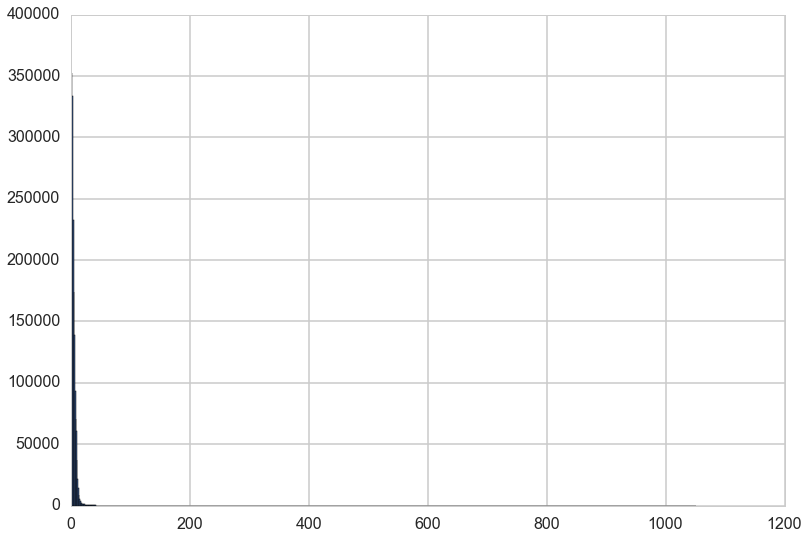

In [29]:
actualPredictedDf["error_in_miles"].hist(bins=1000) #, range =(0,200))

In [165]:
actualPredictedDf.to_csv("./tmplocaldata/final/groupbydestn/destination_prediction.csv", index=False)

#### Reference [link](http://geography.about.com/library/faq/blqzdistancedegree.htm)
Each degree of latitude is approximately 69 miles (111 kilometers) apart. The range varies (due to the earth's slightly ellipsoid shape) from 68.703 miles (110.567 km) at the equator to 69.407 (111.699 km) at the poles. 
A degree of longitude is widest at the equator at 69.172 miles (111.321) and gradually shrinks to zero at the poles. At 40° north or south the distance between a degree of longitude is 53 miles (85 km).

## Appendix

## With sampling

In [72]:
reg = RandomForestRegressor(n_estimators=1, max_depth=20, n_jobs=-1, verbose=4, warm_start=True)
for n in range(1,20):
   reg.set_params(n_estimators=n)
   reg.fit(X_train,y_train) #, sample_weight=pickup_count_train.values)
   training_accuracy = reg.score(X_train, y_train)
   valid_accuracy = reg.score(X_test, y_test)
   rmsetrain = np.sqrt(mean_squared_error(reg.predict(X_train),y_train))
   rmsevalid = np.sqrt(mean_squared_error(reg.predict(X_test),y_test))
   print " R^2 (train) = %0.3f, R^2 (valid) = %0.3f, RMSE (train) = %0.3f, RMSE (valid) = %0.3f" % (training_accuracy, valid_accuracy, rmsetrain, rmsevalid)

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.5s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s


building tree 1 of 1
 R^2 (train) = 0.234, R^2 (valid) = -0.057, RMSE (train) = 0.036, RMSE (valid) = 0.128

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.2s finished
[Parallel(n_jobs=2)]: Done   1 out of   2 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Done   1 out of   2 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Done   1 out of   2 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Done   1 out of   2 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished



building tree 1 of 1
 R^2 (train) = 0.275, R^2 (valid) = 0.016, RMSE (train) = 0.035, RMSE (valid) = 0.123

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.4s finished
[Parallel(n_jobs=3)]: Done   2 out of   3 | elapsed:    2.2s remaining:    1.1s
[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    2.3s remaining:    4.7s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.5s remaining:    1.2s
[Parallel(n_jobs=3)]: Done   2 out of   3 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Done   2 out of   3 | elapsed:    2.2s remaining:    1.1s
[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    2.3s remaining:    4.7s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Done   2 out of   3 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.6s remaining:    1.3


building tree 1 of 1
 R^2 (train) = 0.283, R^2 (valid) = 0.035, RMSE (train) = 0.035, RMSE (valid) = 0.122

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   42.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   42.0s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    2.7s remaining:    8.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.7s remaining:    2.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    2.6s remaining:    7.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.6s finished



building tree 1 of 1
 R^2 (train) = 0.286, R^2 (valid) = 0.055, RMSE (train) = 0.035, RMSE (valid) = 0.121

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.7s remaining:    2.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.2s finished
[Parallel(n_jobs=5)]: Done   1 out of   5 | elapsed:    2.9s remaining:   11.8s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=5)]: Done   1 out of   5 | elapsed:    0.8s remaining:    3.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=5)]: Done   1 out of   5 | elapsed:    3.0s remaining:   12.3


building tree 1 of 1
 R^2 (train) = 0.286, R^2 (valid) = 0.068, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=5)]: Done   1 out of   5 | elapsed:    0.7s remaining:    3.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.4s finished
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    2.8s remaining:    5.7s
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:    2.9s remaining:    1.4s
[Parallel(n_jobs=6)]: Done   1 out of   6 | elapsed:    3.0s remaining:   15.5s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    3.1s finished
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.7s remaining:    1.5s
[Parallel(n_jobs=6)]: Done   1 out of   6 | elapsed:    0.8s remaining:    4.4s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.9s finishe


building tree 1 of 1
 R^2 (train) = 0.288, R^2 (valid) = 0.068, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.9s finished
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:    3.4s remaining:    4.6s
[Parallel(n_jobs=7)]: Done   1 out of   7 | elapsed:    3.4s remaining:   21.2s
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed:    3.5s remaining:    1.3s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    3.5s finished
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:    0.8s remaining:    1.1s
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=7)]: Done   1 out of   7 | elapsed:    0.9s remaining:    5.9s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:    3.4s remaining:    4.5s
[Parallel(n_jobs=7)]: Done   1 out of   7 | elapsed:    3.4s remaining:   20.8s
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed:    3.4s remaini


building tree 1 of 1
 R^2 (train) = 0.288, R^2 (valid) = 0.069, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.5s finished
[Parallel(n_jobs=8)]: Done   7 out of   8 | elapsed:    3.5s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    3.9s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    4.2s remaining:   30.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    1.0s remaining:    7.5s
[Parallel(n_jobs=8)]: Done   7 out of   8 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    3.9s remaining:   27.7s
[Parallel(n_jobs=8)]: Done   7 out of   8 | elapsed:    3.9s remaini


building tree 1 of 1
 R^2 (train) = 0.289, R^2 (valid) = 0.069, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   9 | elapsed:    3.7s remaining:   30.7s
[Parallel(n_jobs=8)]: Done   8 out of   9 | elapsed:    3.9s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    3.9s remaining:   13.8s
[Parallel(n_jobs=8)]: Done   5 out of   9 | elapsed:    3.9s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    1.0s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   5 out of   9 | elapsed:    1.0s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   9 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   1 out of   9 | elapsed:    1.0s remaining:    8.6s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    3.7s remaini


building tree 1 of 1
 R^2 (train) = 0.289, R^2 (valid) = 0.067, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.8s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    3.9s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   1 out of  10 | elapsed:    4.0s remaining:   36.4s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    4.2s remaining:    9.9s
[Parallel(n_jobs=8)]: Done   9 out of  10 | elapsed:    6.0s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   1 out of  10 | elapsed:    0.9s remaining:    9.3s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    1.2s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   9 out of  10 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    3.8s remaini


building tree 1 of 1
 R^2 (train) = 0.289, R^2 (valid) = 0.065, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.5s finished
[Parallel(n_jobs=8)]: Done   4 out of  11 | elapsed:    3.5s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   1 out of  11 | elapsed:    3.7s remaining:   38.4s
[Parallel(n_jobs=8)]: Done   7 out of  11 | elapsed:    3.8s remaining:    2.1s
[Parallel(n_jobs=8)]: Done  10 out of  11 | elapsed:    6.0s remaining:    0.5s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Done   4 out of  11 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   7 out of  11 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of  11 | elapsed:    1.0s remaining:   10.4s
[Parallel(n_jobs=8)]: Done  10 out of  11 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  11 out of  11 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Done   1 out of  11 | elapsed:    3.8s remaini


building tree 1 of 1
 R^2 (train) = 0.290, R^2 (valid) = 0.063, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.4s finished
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    3.7s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   1 out of  12 | elapsed:    3.8s remaining:   42.5s
[Parallel(n_jobs=8)]: Done   2 out of  12 | elapsed:    3.8s remaining:   19.3s
[Parallel(n_jobs=8)]: Done  10 out of  12 | elapsed:    6.4s remaining:    1.2s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Done   1 out of  12 | elapsed:    0.9s remaining:   11.2s
[Parallel(n_jobs=8)]: Done   2 out of  12 | elapsed:    1.0s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  10 out of  12 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Done   6 out of  12 | elapsed:    3.6s remaini


building tree 1 of 1
 R^2 (train) = 0.290, R^2 (valid) = 0.063, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.7s finished
[Parallel(n_jobs=8)]: Done   3 out of  13 | elapsed:    3.7s remaining:   12.7s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    3.8s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   1 out of  13 | elapsed:    4.0s remaining:   48.9s
[Parallel(n_jobs=8)]: Done  11 out of  13 | elapsed:    6.8s remaining:    1.2s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    6.8s finished
[Parallel(n_jobs=8)]: Done   3 out of  13 | elapsed:    0.9s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   7 out of  13 | elapsed:    1.0s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   1 out of  13 | elapsed:    1.0s remaining:   12.5s
[Parallel(n_jobs=8)]: Done  11 out of  13 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Done   1 out of  13 | elapsed:    3.8s remaini


building tree 1 of 1
 R^2 (train) = 0.291, R^2 (valid) = 0.062, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.0s finished
[Parallel(n_jobs=8)]: Done   4 out of  14 | elapsed:    3.7s remaining:    9.4s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    3.8s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   1 out of  14 | elapsed:    3.8s remaining:   51.1s
[Parallel(n_jobs=8)]: Done  12 out of  14 | elapsed:    6.9s remaining:    1.1s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    7.0s finished
[Parallel(n_jobs=8)]: Done   4 out of  14 | elapsed:    0.9s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   1 out of  14 | elapsed:    0.9s remaining:   13.1s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=8)]: Done  12 out of  14 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Done   4 out of  14 | elapsed:    3.8s remaini


building tree 1 of 1
 R^2 (train) = 0.291, R^2 (valid) = 0.063, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   40.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   40.8s finished
[Parallel(n_jobs=8)]: Done   1 out of  15 | elapsed:    3.7s remaining:   52.7s
[Parallel(n_jobs=8)]: Done   5 out of  15 | elapsed:    3.8s remaining:    7.6s
[Parallel(n_jobs=8)]: Done   9 out of  15 | elapsed:    7.1s remaining:    4.7s
[Parallel(n_jobs=8)]: Done  13 out of  15 | elapsed:    7.1s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    7.2s finished
[Parallel(n_jobs=8)]: Done   5 out of  15 | elapsed:    1.0s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   1 out of  15 | elapsed:    1.0s remaining:   15.1s
[Parallel(n_jobs=8)]: Done   9 out of  15 | elapsed:    1.8s remaining:    1.1s
[Parallel(n_jobs=8)]: Done  13 out of  15 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Done   1 out of  15 | elapsed:    3.8s remaini


building tree 1 of 1
 R^2 (train) = 0.291, R^2 (valid) = 0.063, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   41.1s finished
[Parallel(n_jobs=8)]: Done   8 out of  16 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   1 out of  16 | elapsed:    3.9s remaining:  1.0min
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:    4.1s remaining:   18.1s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    7.5s remaining:    1.6s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    7.5s finished
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:    1.0s remaining:    4.6s
[Parallel(n_jobs=8)]: Done   1 out of  16 | elapsed:    1.0s remaining:   16.1s
[Parallel(n_jobs=8)]: Done   8 out of  16 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    1.9s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:    3.7s remaini


building tree 1 of 1
 R^2 (train) = 0.291, R^2 (valid) = 0.065, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.4s finished
[Parallel(n_jobs=8)]: Done   4 out of  17 | elapsed:    3.5s remaining:   11.7s
[Parallel(n_jobs=8)]: Done   1 out of  17 | elapsed:    3.8s remaining:  1.0min
[Parallel(n_jobs=8)]: Done   9 out of  17 | elapsed:    7.1s remaining:    6.3s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    7.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    9.3s finished
[Parallel(n_jobs=8)]: Done   4 out of  17 | elapsed:    0.8s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   1 out of  17 | elapsed:    1.0s remaining:   18.2s
[Parallel(n_jobs=8)]: Done   9 out of  17 | elapsed:    1.8s remaining:    1.6s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Done   4 out of  17 | elapsed:    3.6s remaini


building tree 1 of 1
 R^2 (train) = 0.291, R^2 (valid) = 0.065, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.1s finished
[Parallel(n_jobs=8)]: Done   1 out of  18 | elapsed:    3.9s remaining:  1.1min
[Parallel(n_jobs=8)]: Done   5 out of  18 | elapsed:    4.0s remaining:   10.7s
[Parallel(n_jobs=8)]: Done  10 out of  18 | elapsed:    7.6s remaining:    6.1s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    7.9s remaining:    1.5s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    9.8s finished
[Parallel(n_jobs=8)]: Done   1 out of  18 | elapsed:    0.9s remaining:   16.8s
[Parallel(n_jobs=8)]: Done   5 out of  18 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=8)]: Done  10 out of  18 | elapsed:    1.9s remaining:    1.5s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Done   5 out of  18 | elapsed:    3.9s remaini


building tree 1 of 1
 R^2 (train) = 0.291, R^2 (valid) = 0.065, RMSE (train) = 0.035, RMSE (valid) = 0.120

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   40.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   40.1s finished
[Parallel(n_jobs=8)]: Done   6 out of  19 | elapsed:    3.9s remaining:    8.6s
[Parallel(n_jobs=8)]: Done   1 out of  19 | elapsed:    3.9s remaining:  1.2min
[Parallel(n_jobs=8)]: Done  11 out of  19 | elapsed:    7.5s remaining:    5.5s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    8.0s remaining:    1.4s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:   10.3s finished
[Parallel(n_jobs=8)]: Done   6 out of  19 | elapsed:    1.1s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   1 out of  19 | elapsed:    1.1s remaining:   20.9s
[Parallel(n_jobs=8)]: Done  11 out of  19 | elapsed:    2.1s remaining:    1.5s
[Parallel(n_jobs=8)]: Done  16 out of  19 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  19 out of  19 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Done   6 out of  19 | elapsed:    3.8s remaini


building tree 1 of 1
 R^2 (train) = 0.291, R^2 (valid) = 0.062, RMSE (train) = 0.035, RMSE (valid) = 0.120


In [63]:
#With weighted sampling: 20 estimators, 20 depth
print "RMSE= ",np.sqrt(mean_squared_error(best.predict(X_test),y_test))

RMSE=  0.118465757808


## Without sampling

In [68]:
%%time
# Define a grid of parameters over which to optimize the random forest
# We will figure out which number of trees is optimal
parameters = {"n_estimators": [20],
              "max_features": ["auto"], # ["auto","sqrt","log2"]
              "max_depth": [20]}
best = cv_optimize(estimator, parameters, X_train, y_train, n_folds=2, verbose=3)
#best = cv_optimize(estimator, parameters, X_train, y_train, n_folds=2, score_func='mean_squared_error', verbose=3)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] max_features=auto, n_estimators=20, max_depth=20 ................
[CV]  max_features=auto, n_estimators=20, max_depth=20, score=0.133406 - 3.3min
[CV] max_features=auto, n_estimators=20, max_depth=20 ................
[CV]  max_features=auto, n_estimators=20, max_depth=20, score=0.138348 - 3.2min

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  3.3min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.5min finished



BEST {'max_features': 'auto', 'n_estimators': 20, 'max_depth': 20} 0.13587711428 [mean: 0.13588, std: 0.00247, params: {'max_features': 'auto', 'n_estimators': 20, 'max_depth': 20}] <function _passthrough_scorer at 0x00000000204DB7B8>
Best score:  0.13587711428
Wall time: 13min 30s


In [69]:
#Without weighted sampling: 20 estimators, 20 depth
print "RMSE= ",np.sqrt(mean_squared_error(best.predict(X_test),y_test))

RMSE=  0.111710488577


## Backup

### Outcome

The best RMSE value that we got was 0.120. In NYC each longitude is approx 53 miles & latitude is approx 69 miles (see reference below). This gives an **error range of 6.36 x 8.28 square miles**. So we do not have a great predictor here (but a great learning experience in modeling this problem)

note: 1. We have not standardized lat & long in same scale - ideally this shd be done part of data prep. This would have given us a RMSE that we can apply properly to find exact error in distance.